###Imports

In [15]:
import os
os.chdir('/home/research/yu.zihao/pnp/plug_and_play_admm/')
print(os.getcwd())

/home/research/yu.zihao/pnp/plug_and_play_admm


In [16]:
from model import Unet
from pnp import pnp_admm
from utils import conv2d_from_kernel, compute_psnr, ImagenetDataset, myplot

import torch
import torch.nn.functional as F

import PIL.Image as Image


device = 'cuda'

In [3]:
# ! pip install gdown


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


###Download plug-in denoiser

In [17]:
import gdown
url = 'https://drive.google.com/file/d/1FFuauq-PUjY_kG3iiiHfDpHcG4Srl8mQ/view?usp=sharing'
output = "denoiser.pth"
gdown.download(url, output, quiet=False,fuzzy=True)

model = Unet(3, 3, chans=64).to(device)
model.load_state_dict(torch.load('denoiser.pth', map_location=device))
print('#Parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

Downloading...
From (original): https://drive.google.com/uc?id=1FFuauq-PUjY_kG3iiiHfDpHcG4Srl8mQ
From (redirected): https://drive.google.com/uc?id=1FFuauq-PUjY_kG3iiiHfDpHcG4Srl8mQ&confirm=t&uuid=efe30902-9691-48b8-ab14-30814af2e6c0
To: /home/research/yu.zihao/pnp/plug_and_play_admm/denoiser.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124M/124M [00:03<00:00, 32.4MB/s]
/tmp/ipykernel_2335000/3163620327.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary ob

#Parameters: 31025027


In [18]:
model

Unet(
  (down_sample_layers): ModuleList(
    (0): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropout2d(p=0.0, inplace=False)
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (6): LeakyReLU(negative_slope=0.2, inplace=True)
        (7): Dropout2d(p=0.0, inplace=False)
      )
    )
    (1): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropou

###Plug and play examples

####Load test image

In [19]:
# Get sample
test_image = Image.open('figs/brookings.webp').convert("RGB")
test_image = ImagenetDataset([]).test_transform(test_image)
# test_image = dataset[1231]['target'] # from dataset
channels, h, w = test_image.shape
test_image = test_image.unsqueeze(0).to(device)

####Motion deblur

PSNR [dB]: 30.00


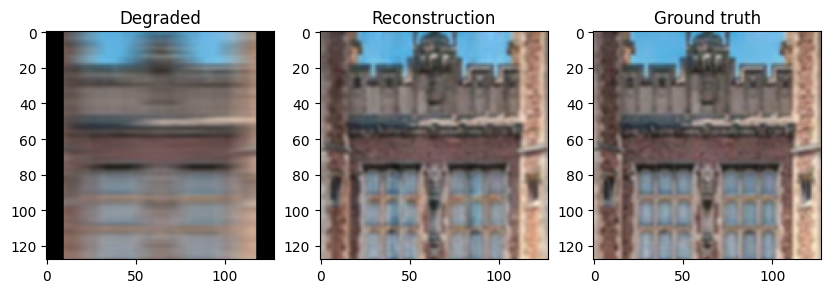

In [20]:
# Motion deblur
kernel_size = 21
kernel_motion_blur = torch.ones((1, kernel_size))
forward, forward_adjoint = conv2d_from_kernel(kernel_motion_blur, channels, device)

# Run plug and play
y = forward(test_image)
with torch.no_grad():
    model.eval()
    x = pnp_admm(y, forward, forward_adjoint, model)
    x = x.clip(0,1)

# Plot
print('PSNR [dB]: {:.2f}'.format(compute_psnr(x, test_image)))
myplot(F.pad(y, (kernel_size//2, kernel_size//2)), x, test_image)

PSNR [dB]: 21.70


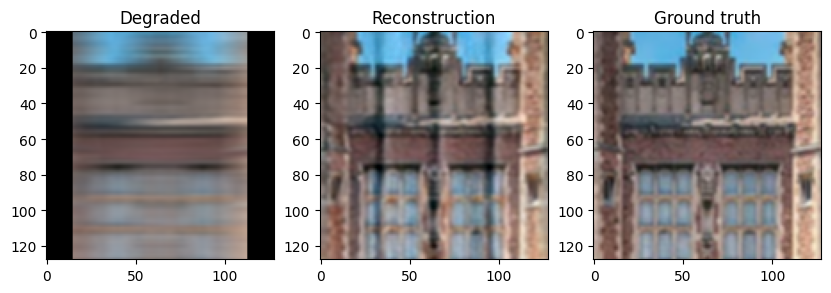

In [20]:
# Increase the Kernel Size

kernel_size = 31
kernel_motion_blur = torch.ones((1, kernel_size))
forward, forward_adjoint = conv2d_from_kernel(kernel_motion_blur, channels, device)

# Run plug and play
y = forward(test_image)
with torch.no_grad():
    model.eval()
    x = pnp_admm(y, forward, forward_adjoint, model)
    x = x.clip(0,1)

# Plot
print('PSNR [dB]: {:.2f}'.format(compute_psnr(x, test_image)))
myplot(F.pad(y, (kernel_size//2, kernel_size//2)), x, test_image)

####Inpainting

PSNR [dB]: 30.97


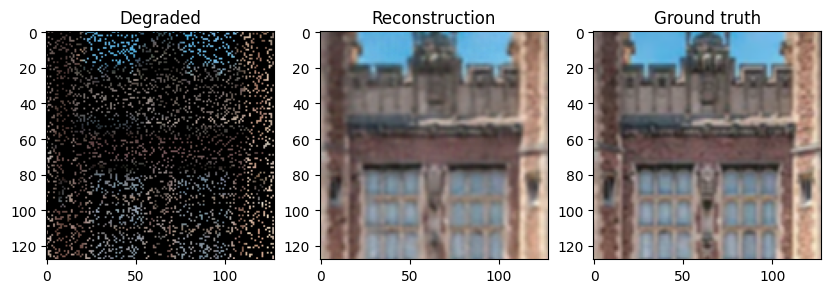

In [21]:
# Inpainting
mask = torch.rand(1,1,h,w).to(device)
mask = mask < 0.2

def forward(x):
    return x*mask
forward_adjoint = forward

# Run plug and play
y = forward(test_image)
with torch.no_grad():
    model.eval()
    x = pnp_admm(y, forward, forward_adjoint, model, num_iter=100)
    x = x.clip(0,1)

# Plot
print('PSNR [dB]: {:.2f}'.format(compute_psnr(x, test_image)))
myplot(y, x, test_image)

####Super-resolution

PSNR [dB]: 25.28


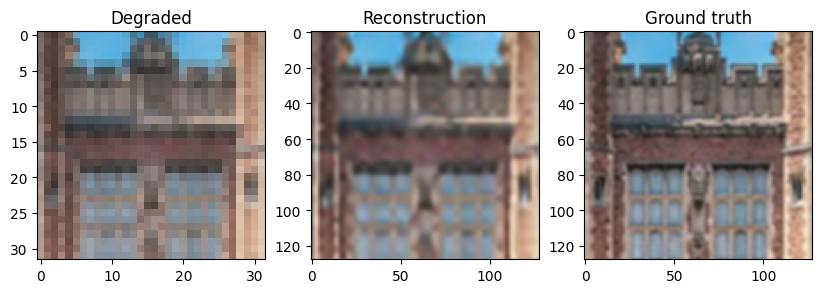

In [22]:
# Super-resolultion
kernel_size = 4
kernel_downsampling = torch.ones((kernel_size, kernel_size))
forward, forward_adjoint = conv2d_from_kernel(kernel_downsampling, channels, device, stride=kernel_size)

# Run plug and play
y = forward(test_image)
with torch.no_grad():
    model.eval()
    x = pnp_admm(y, forward, forward_adjoint, model, num_iter=100, max_cgiter=30, cg_tol=1e-4)
    x = x.clip(0,1)

# Plot
print('PSNR [dB]: {:.2f}'.format(compute_psnr(x, test_image)))
myplot(y, x, test_image)